__Задание 1:__ Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность.


__Решение__

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


__Функции для работы алгоритма:__

In [53]:
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

__Загрузим данные и обработаем их:__

In [54]:
with open('/content/drive/MyDrive/ГБ/выборки для исследований/Iris.csv', "rb") as f:
    iris_data = pd.read_csv(f)

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

__Реализую нейросеть в функцию и создаю кастомный решетчатый поиск(без кросс валидации):__

In [72]:
def make_neuro(neuron_numb, learn_rate, n_iter):

  # присваевание случайных весов
  np.random.seed(0) # фиксирую одинаковую рандомность 
  w0 = 2*np.random.random((4, neuron_numb)) - 1 # для входного слоя   - 4 входа, neuron_numb выхода
  w1 = 2*np.random.random((neuron_numb, 3)) - 1 # для внутреннего слоя - neuron_numb входов, 3 выхода

  # массив для ошибок, чтобы потом построить график
  errors = []

  # процесс обучения
  for i in range(n_iter):

      # прямое распространение(feed forward)
      layer0 = X_train
      layer1 = sigmoid(np.dot(layer0, w0))
      layer2 = sigmoid(np.dot(layer1, w1))

      # обратное распространение(back propagation) с использованием градиентного спуска
      layer2_error = y_train - layer2                    # производная функции потерь
      layer2_delta = layer2_error * sigmoid_deriv(layer2)
      
      layer1_error = layer2_delta.dot(w1.T)   # шаг обратного распространения
      layer1_delta = layer1_error * sigmoid_deriv(layer1)
      
      w1 += layer1.T.dot(layer2_delta) * learn_rate
      w0 += layer0.T.dot(layer1_delta) * learn_rate
      
      error = np.mean(np.abs(layer2_error))
      errors.append(error)
      accuracy = (1 - error) * 100  # это не аккураси, проверить формулу.

  return accuracy, errors, layer2


def Grid_Search_neuro(params):
  results_list = ['nothing', 0]

  for n in params['neuron_numb']:
    for rate in params['learn_rate']:
      for iter in params['n_iter']:
        result = make_neuro(neuron_numb=n,learn_rate=rate, n_iter=iter)

        if result[0] > results_list[1]:
          results_list = [f'Best params: neuron_numb={n}, learn_rate={rate}, n_iter={iter}', result[0]]

  return results_list[0], f'with accuracy: {results_list[1]}'

In [77]:
%%time

params_for_neuro = {'neuron_numb': range(1,7),
                    'learn_rate': [0.0001, 0.001, 0.01, 0.1, 1],
                    'n_iter': [100, 1000,10000]}

Grid_Search_neuro(params_for_neuro)

<ipython-input-53-5399696661e6>:21: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


CPU times: user 28.7 s, sys: 167 ms, total: 28.8 s
Wall time: 28.9 s


('Best params: neuron_numb=6, learn_rate=0.1, n_iter=10000',
 'with accuracy: 97.87253712531243')

__Задание 2:__ Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

__Решение__

<function matplotlib.pyplot.grid(b=None, which='major', axis='both', **kwargs)>

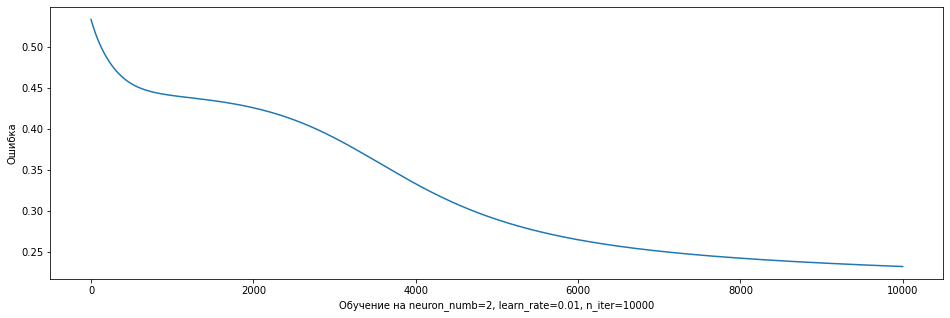

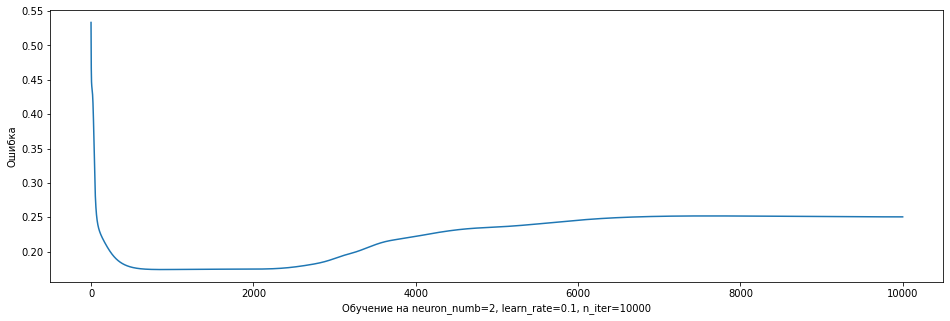

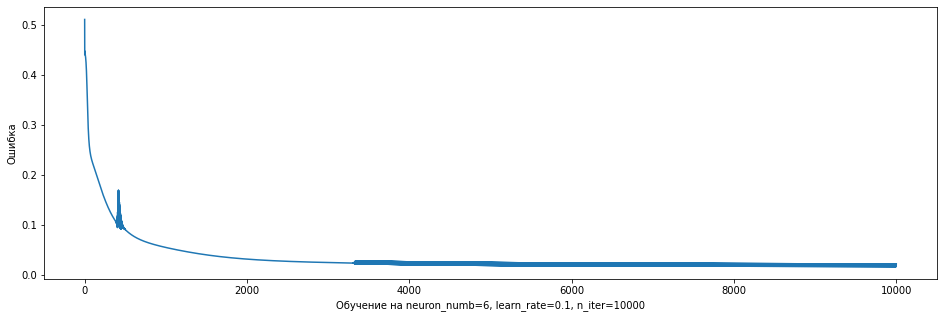

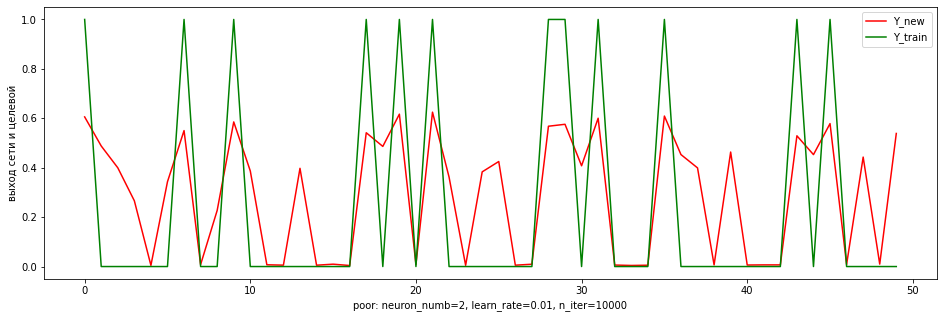

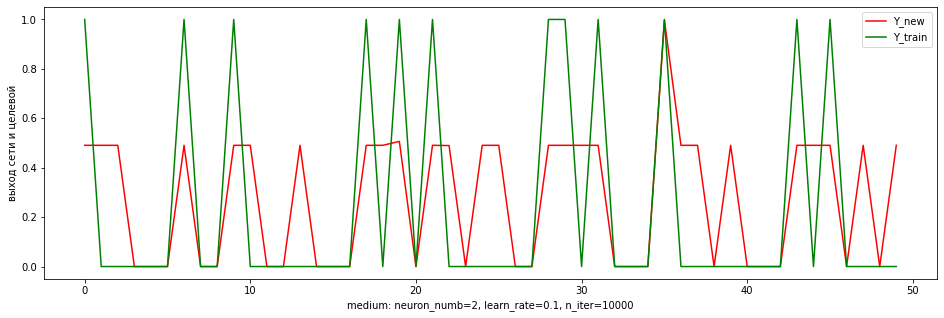

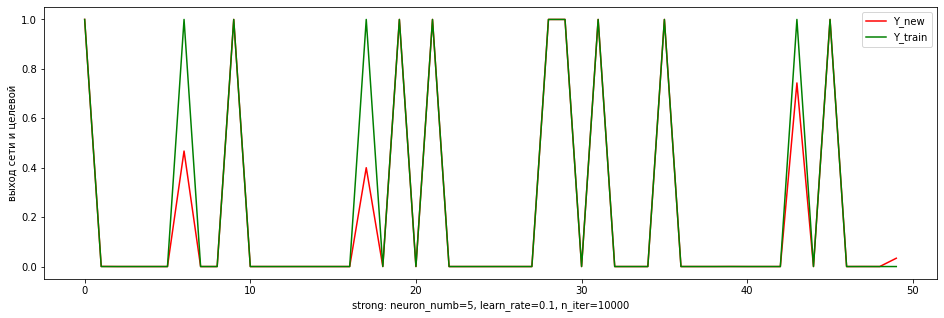

In [80]:
nero_poor = make_neuro(neuron_numb=2, learn_rate=0.001, n_iter=10000)
nero_medium = make_neuro(neuron_numb=2, learn_rate=0.1, n_iter=10000) # изменил только скорость
nero_strong = make_neuro(neuron_numb=6, learn_rate=0.1, n_iter=10000) # изменил и скорость и число нейронов относительно первого

plt.figure(figsize=(16,5))
plt.plot(nero_poor[1])
plt.xlabel('Обучение на neuron_numb=2, learn_rate=0.01, n_iter=10000')
plt.ylabel('Ошибка')
plt.grid

plt.figure(figsize=(16,5))
plt.plot(nero_medium[1])
plt.xlabel('Обучение на neuron_numb=2, learn_rate=0.1, n_iter=10000')
plt.ylabel('Ошибка')
plt.grid

plt.figure(figsize=(16,5))
plt.plot(nero_strong[1])
plt.xlabel('Обучение на neuron_numb=6, learn_rate=0.1, n_iter=10000')
plt.ylabel('Ошибка')
plt.grid


N = 50
plt.figure(figsize=(16,5))
plt.plot(nero_poor[2][:N, 1], 'r', label='Y_new')
plt.plot(y_train[:N, 1], 'g', label='Y_train')
plt.xlabel('poor: neuron_numb=2, learn_rate=0.01, n_iter=10000')
plt.ylabel('выход сети и целевой')
plt.legend()
plt.grid

plt.figure(figsize=(16,5))
plt.plot(nero_medium[2][:N, 1], 'r', label='Y_new')
plt.plot(y_train[:N, 1], 'g', label='Y_train')
plt.xlabel('medium: neuron_numb=2, learn_rate=0.1, n_iter=10000')
plt.ylabel('выход сети и целевой')
plt.legend()
plt.grid

plt.figure(figsize=(16,5))
plt.plot(nero_strong[2][:N, 1], 'r', label='Y_new')
plt.plot(y_train[:N, 1], 'g', label='Y_train')
plt.xlabel('strong: neuron_numb=5, learn_rate=0.1, n_iter=10000')
plt.ylabel('выход сети и целевой')
plt.legend()
plt.grid

In [81]:
nero_poor[0],nero_medium[0], nero_strong[0]

(76.81662822549507, 74.92867424146763, 97.87253712531243)

Что мы видим на данных графиках: <br>

1) Судя по-всему, скорость обучения зависимо от кол-ва нейронов, т.е. на первых двух графиках видим что средняя модель работает хуже чем бедная. Вероятно, понижать скорость обучения при неизменном кол-ве нейронов не следует. Также косвенное наблюдение, что средняя модель достигает лучших результатов на 2000 итерациях и ее лучше обрубать там.<br>

<br>

2) При изменении числа нейронов в большую сторону и уменьшении скорости обучения модель отрабатывает лучше. Возможно в ее можно обрубать и в районе 4000 итераций, если бы у бизнеса стал вопрос в ликвиде мощностей.